In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata
%matplotlib inline

In [2]:
# https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k
fremont_bridge_bike_counts = '4xy5-26gy'
with Socrata("data.seattle.gov", os.environ['socrata_app_token']) as client:
    data = client.get(fremont_bridge_bike_counts, order='date', limit=100)

In [3]:
df = pd.DataFrame(data)

In [4]:
df.columns

Index(['date', 'fremont_bridge_nb', 'fremont_bridge_sb'], dtype='object')

In [5]:
df['date'] = df.date.astype(np.datetime64)
df['fremont_bridge_nb'] = df.fremont_bridge_nb.astype('int32')
df['fremont_bridge_sb'] = df.fremont_bridge_sb.astype('int32')

In [6]:
df.head()

,date,fremont_bridge_nb,fremont_bridge_sb
0,2012-10-03 00:00:00,4,9
1,2012-10-03 01:00:00,4,6
2,2012-10-03 02:00:00,1,1
3,2012-10-03 03:00:00,2,3
4,2012-10-03 04:00:00,6,1


In [7]:
df.tail()

,date,fremont_bridge_nb,fremont_bridge_sb
95,2012-10-06 23:00:00,15,19
96,2012-10-07 00:00:00,6,5
97,2012-10-07 01:00:00,12,5
98,2012-10-07 02:00:00,2,1
99,2012-10-07 03:00:00,4,2


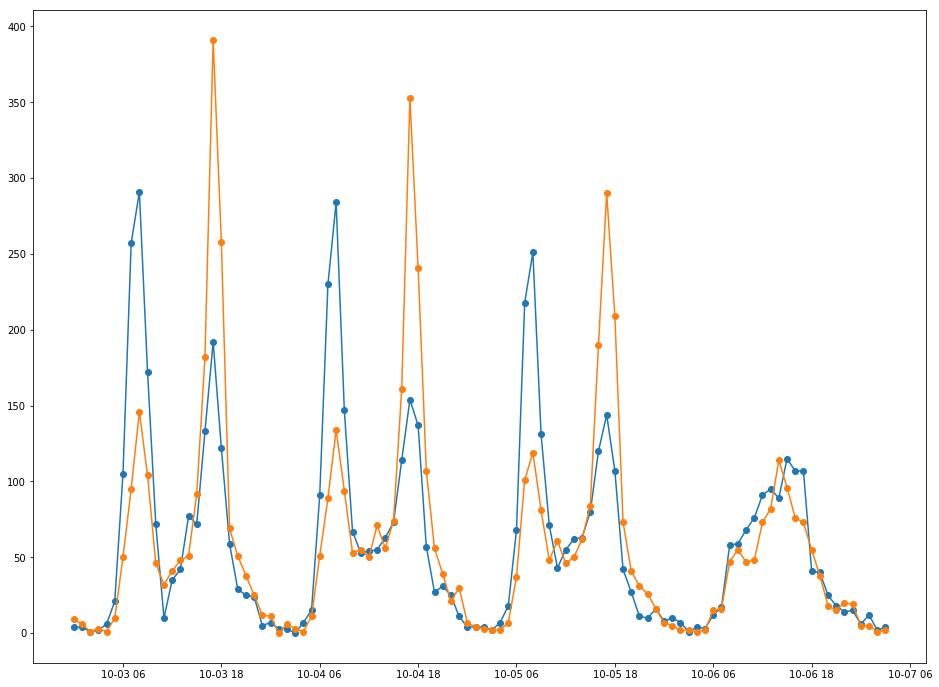

In [8]:
plt.figure(figsize=(16, 12))
plt.plot_date(df.date, df.fremont_bridge_nb, ls='solid')
plt.plot_date(df.date, df.fremont_bridge_sb, ls='solid');